# Un caso más complicado: gatos contra perros
Otro problema de clasificación, pero esta vez con imágenes más complejas

##Datos de entrenamiento

Esta vez no vamos a utilizar un dataset integrado en Keras. Nos descargamos el dataset directamente de internet. He creado una versión reducida del dataset [Dogs & Cats Images](https://www.kaggle.com/chetankv/dogs-cats-images?) disponible en Kaggle.

La versión que vamos a utilizar ocupa 180MB y contiene imágenes clasificadas de perros y gatos.

Con este código descargamos el dataset de internet y lo descomprimimos, además de definir el nombre que le daremos a cada categoría.

Los entrenamientos empiezan a llevar cada vez más tiempo, puede ser buena idea guardar el modelo entrenado en algún lugar seguro por si queremos dejar la instancia entrenando por la noche. Recordad que el uso de Google Colab está bastante limitado y nunca podréis tener un runtime en ejecución más de 12 horas con la versión gratuita.

Podemos ver el código necesario para montar nuestro Google Drive en la estructura de directorios del sistema en la siguiente celda

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')

if not os.path.exists('cats_and_dogs_filtered.zip'):
  !curl -O https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q -o cats_and_dogs_filtered.zip

class_names = ['Cat', 'Dog']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Definimos algunas constantes que nos servirán en los siguientes entrenamientos, ya que serán todos sobre el mismo dataset

In [ ]:
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)
train_dir = 'cats_and_dogs_filtered/train'
test_dir = 'cats_and_dogs_filtered/validation'
train_count = 2000
test_count = 1000
batch_size = 256

Esta vez, al ser un dataset pesado, utilizamos un ImageDataGenerator, que nos va proporcionando imágenes por batches, en lugar de cargar todas de golpe en memoria. Además, esta clase se puede encargar de normalizar los datos, redimensionar las imágenes, convertir los labels a formato hot encoded y separar los sets de entrenamiento y validación.

De nuevo, mostramos imágenes aleatorias.

Found 2000 images belonging to 2 classes.


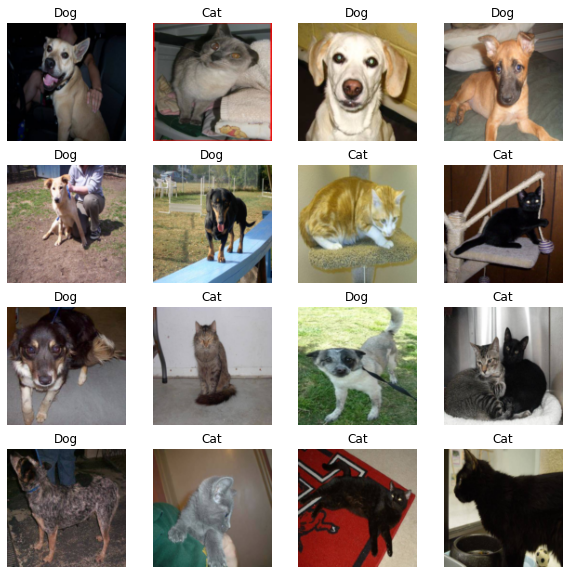

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1 / 255)
test_datagen = ImageDataGenerator(rescale=1 / 255)

(x_batch, y_batch) = next(train_datagen.flow_from_directory(train_dir, batch_size=batch_size,
                                                target_size=(img_width, img_height),
                                                interpolation='bilinear'))

plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.title(class_names[int(np.argmax(y_batch[i]))])
  plt.imshow(x_batch[i])
  plt.axis('off')

A partir del ImageDataGenerator que acabamos de crear, construimos dos generadores, uno para obtener los datos de entrenamiento y otro para los de validación.

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=batch_size,
                                              target_size=(img_width, img_height),
                                              interpolation='bilinear')
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=batch_size,
                                            target_size=(img_width, img_height),
                                            interpolation='bilinear')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Definición del modelo

Utilizamos el mismo modelo que antes, pero tenemos que adaptarlo a las caracterísitcas del nuevo dataset: las imágenes tienen un shape de (128, 128, 3) y el número de posibles clases a predecir es 2.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def create_simple_cats_and_dogs_model():
  m = Sequential([
                  Flatten(input_shape=input_shape),
                  Dense(256, activation='relu'),
                  Dense(2, activation='softmax'),])
  m.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
  return m

## Entrenamiento

Volvemos a entrenar, esta vez durante 25 epochs y monitorizamos el aprendizaje de nuestra red.

Además, al tener ahora una fuente de datos "ilimitada", tenemos que especificarle cuántos batches queremos que entrene por cada epoch. Esto se hace con el parámetro **steps_per_epoch**. Las imágenes con las que trabaja cada iteración se eligen al azar para que no estemos utilizando exactamente las mismas imágenes en cada epoch.

Pasa exactamente lo mismo con los datos de validación, especificamos el parámetro **validation_steps**

In [ ]:
model_sim_cad = create_simple_cats_and_dogs_model()
history_sim_cad = model_sim_cad.fit(train_generator, steps_per_epoch=train_count//batch_size,
                                epochs=25, validation_data=test_generator,
                                validation_steps=test_count//batch_size)

Epoch 1/25
7/7 [==============================] - 12s 2s/step - loss: 35.9158 - accuracy: 0.4967 - val_loss: 10.9682 - val_accuracy: 0.5078
Epoch 2/25
7/7 [==============================] - 10s 2s/step - loss: 6.1923 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5065
Epoch 3/25
7/7 [==============================] - 10s 2s/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 4/25
7/7 [==============================] - 10s 2s/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 5/25
7/7 [==============================] - 10s 2s/step - loss: 0.6931 - accuracy: 0.5065 - val_loss: 0.6931 - val_accuracy: 0.5026
Epoch 6/25
7/7 [==============================] - 10s 2s/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6934 - val_accuracy: 0.4883
Epoch 7/25
7/7 [==============================] - 10s 2s/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.4948
Epoch 8/25
7/7 [================

## Guardando el modelo

Lo guardamos en nuestro drive, previamente montado. Es importante que la ruta de destino exista en drive. Aquí podemos ver cómo guardar y cargar el modelo:


In [ ]:
from keras.models import load_model

path = './gdrive/MyDrive/Colab Notebooks/Data/cats_ands_dogs.h5'
model_sim_cad.save(path)
model_loaded = load_model(path)
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12583168  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 12,583,682
Trainable params: 12,583,682
Non-trainable params: 0
_________________________________________________________________


## Interpretación de las métricas
La métrica importante es la de precisión cuando clasifica imágenes
que no haya visto antes (Validation Accuracy)
* La tasa de acierto de nuestra red oscila, sin llegar estabilizarse mucho más allá del 50%
* La red está teniendo dificultades para aprender

In [ ]:
def show_training_graph(data):
  acc = data.history['accuracy']
  val_acc = data.history['val_accuracy']
  loss = data.history['loss']
  val_loss = data.history['val_loss']

  epochs = range(len(acc))
  plt.figure(figsize=(11, 8))
  plt.subplot(1, 2, 1)
  plt.grid(True)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.title('Evolución de la precisión en entrenamiento y validación')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.grid(True)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Evolución de loss en entrenamiento y validación')
  plt.legend(loc='upper right')

  plt.show()

#show_training_graph(history_sim_cad)

# Nuevo intento: mejorando nuestro clasificador de perros y gatos con convoluciones

La arquitectura anterior no es capaz de aprender para solventar clasificaciones de imágenes más complejas.
Vamos a implementar una de las evoluciones más importantes en visión por computador con deep learning: las **redes convolucionales**

## Definición del modelo

Vamos a aumentar la profundidad de nuestro modelo y a implementar dos nuevos tipos de capa para convertirlo en un clasificador mucho más potente:

### Las nuevas capas: Conv2D y MaxPooling

* El núcleo de nuestro modelo serán las capas **Conv2D**. Una convolución permite detectar patrones complejos en una imagen, como por ejemplo detectar bordes. Si encadenamos varias capas convolucionales, cada vez detectarán características más abstractas. Con el padding en *same*, la imagen de salida tendrá el mismo tamaño que la de entrada.

* Las capas **MaxPool2D** reducen el tamaño de la imagen. Esto ayuda a tener partes de la red más especializadas en los pequeños detalles y partes que se especializan en detectar patrones más grandes. Las convoluciones de 3x3 abarcan una parte muy pequeña de la imagen original de 128x128, por lo que mediante Max Pooling reducimos la imagen sucesivamente (como si hiciésemos diferentes niveles de zoom) para que las convoluciones vayan captando características de diferentes tamaños.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

def create_conv_model():
  m = Sequential([
                  Conv2D(32, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  
                  Conv2D(64, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),
                  
                  Conv2D(128, (3, 3), padding='same', activation='relu'),
                  MaxPooling2D((2, 2)),

                  Flatten(),
                  Dense(512, activation='relu'),
                  Dense(2, activation='softmax'),])

  m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return m

## Entrenamiento del modelo convolucional

Mismo proceso de entrenamiento que en el caso anterior.

In [ ]:
model_conv = create_conv_model()
history_conv = model_conv.fit(train_generator, steps_per_epoch=train_count//batch_size,
                    epochs=20, validation_data=test_generator,
                    validation_steps=test_count//batch_size)
model_conv.save('cad_conv.h5')

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 3.1416 - accuracy: 0.5007 - val_loss: 0.6993 - val_accuracy: 0.4909
Epoch 2/20
7/7 [==============================] - 11s 2s/step - loss: 0.6939 - accuracy: 0.5119 - val_loss: 0.6922 - val_accuracy: 0.4974
Epoch 3/20
7/7 [==============================] - 11s 2s/step - loss: 0.6911 - accuracy: 0.5146 - val_loss: 0.6876 - val_accuracy: 0.5117
Epoch 4/20
7/7 [==============================] - 11s 2s/step - loss: 0.6899 - accuracy: 0.5246 - val_loss: 0.6852 - val_accuracy: 0.5339
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.6767 - accuracy: 0.5849 - val_loss: 0.6654 - val_accuracy: 0.6393
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 0.6590 - accuracy: 0.6326 - val_loss: 0.6677 - val_accuracy: 0.5690
Epoch 7/20
7/7 [==============================] - 11s 2s/step - loss: 0.6310 - accuracy: 0.6397 - val_loss: 0.6394 - val_accuracy: 0.6211
Epoch 8/20
7/7 [==================

## Interpretación de las métricas

Al principio, las métricas de datos de validación son muy similares a las de entrenamiento, pero se separan rápidamente.

* El accuracy en datos de entrenamiento se roza el 100%
* Para los de validación, se queda torno al 72%, estabilizándose al principio del entrenamiento.
  * Este es un claro caso de overfitting:
    * En el caso anterior, nuestro modelo no era lo suficientemente potente como para aprender de los datos.
    * Esta vez, la red ha visto tantas veces las mismas imágenes, que en vez de generalizar, ha memorizado los datos para las imágenes de entrenamiento.
    * El dataset se le queda muy pequeño a nuestra arquitectura.
    * El hecho de que la función de loss en validación no se estabilice también apunta en esta dirección.
* Queremos que la red sea capaz de clasificar imágenes que no haya visto antes, por lo que la métrica importante es la de accuracy en validación
Aún así, tenemos una precisión del 72% con datos de validación, superando el 57% que obtuvimos antes

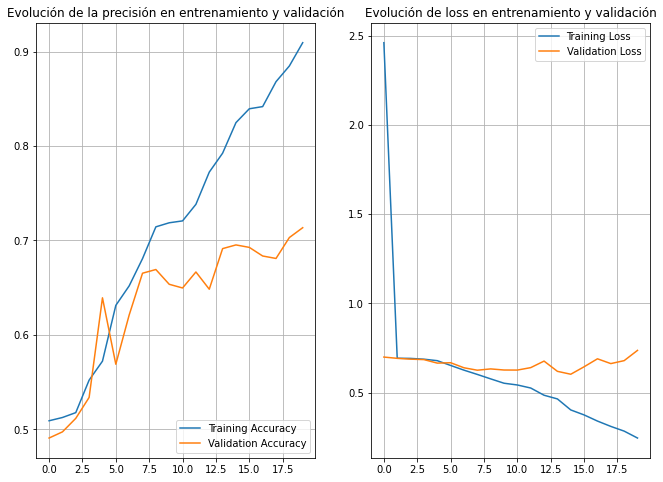

In [ ]:
show_training_graph(history_conv)

### TODO: Mejorar el modelo implementando Augmentation y Dropout

Analizar los resultados con gráficas, como en los ejemplos anteriores

In [ ]:
#
from keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def modeloDropOut():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='sigmoid'))
  # Compilamos el modelo
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	
  return model


In [ ]:
#Augmentation
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 30,
                                   zoom_range = 0.15)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    batch_size=batch_size, 
                                                    target_size=(img_width, img_height),
                                                    interpolation='bilinear')
  

Found 2000 images belonging to 2 classes.


In [ ]:
modeloDropout = modeloDropOut()
data= modeloDropout.fit(train_generator, steps_per_epoch=train_count//batch_size,
                       epochs=25,validation_data=test_generator,
                       validation_steps= test_count//batch_size)

modeloDropout.save('cad_conv.h5')

Epoch 1/25
7/7 [==============================] - 17s 2s/step - loss: 2.8092 - accuracy: 0.5102 - val_loss: 0.6974 - val_accuracy: 0.5026
Epoch 2/25
7/7 [==============================] - 15s 2s/step - loss: 0.7003 - accuracy: 0.5065 - val_loss: 0.7007 - val_accuracy: 0.4974
Epoch 3/25
7/7 [==============================] - 15s 2s/step - loss: 0.7010 - accuracy: 0.4908 - val_loss: 0.6911 - val_accuracy: 0.5052
Epoch 4/25
7/7 [==============================] - 15s 2s/step - loss: 0.6921 - accuracy: 0.5063 - val_loss: 0.6885 - val_accuracy: 0.5755
Epoch 5/25
7/7 [==============================] - 15s 2s/step - loss: 0.6877 - accuracy: 0.5676 - val_loss: 0.6820 - val_accuracy: 0.5495
Epoch 6/25
7/7 [==============================] - 15s 2s/step - loss: 0.6807 - accuracy: 0.5851 - val_loss: 0.6659 - val_accuracy: 0.6172
Epoch 7/25
7/7 [==============================] - 15s 2s/step - loss: 0.6740 - accuracy: 0.5854 - val_loss: 0.6583 - val_accuracy: 0.6263
Epoch 8/25
7/7 [==================

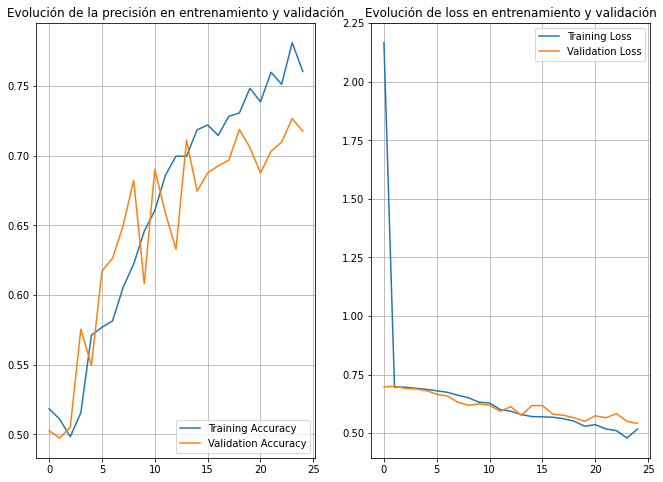

In [ ]:
show_training_graph(data)